# Baseline Neural Network Setup using k-fold Cross Validation

In [1]:
# library dependencies
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import lzma
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import keras
from keras import layers
import tensorflow as tf
import keras_tuner
import math
import time

2024-02-09 22:40:21.391429: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-09 22:40:21.392783: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-09 22:40:21.410367: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-09 22:40:21.410385: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-09 22:40:21.410887: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
# method to store data as serialized binary structure lzma compressed
def can_pickles(data, filename):
    with lzma.LZMAFile(filename, 'wb') as f:
        pickle.dump(data, f, pickle.DEFAULT_PROTOCOL)

# method to retrieve data from a compressed pickle file (created with the method above)
def uncan_pickles(filename):
    with lzma.LZMAFile(filename, 'rb') as f:
        return pickle.load(f)

In [3]:
# helper method to create a valid dataset
# padded batches from ragged tensors are not supported (yet)
# it needs a work around creating a uniform tensor
# idea from : https://github.com/tensorflow/tensorflow/issues/39163
def reformat(data, label):
    return data, label

# method to create a TF dataset
def create_dataset(X_np_array, y_np_array, batch_size=32, sort=False):
    # sort the arrays
    if sort == True:
        # build an array containing the sequence lengths
        sequence_lengths = list(map(lambda x: len(x), X_np_array))
        # sort the array but only get the indices
        sorted_indices = np.argsort(sequence_lengths)
        # now sort the X and y train arrays according to the sorted indicds
        X_np_array = X_np_array[sorted_indices]
        y_np_array = y_np_array[sorted_indices]

    # create ragged tensor from in-homogeneous array
    # X_tensor = tf.ragged.constant(X1_np_array, dtype=tf.int8, ragged_rank=1, row_splits_dtype=tf.int32)
    # https://github.com/tensorflow/tensorflow/issues/47853
    X_tensor = tf.RaggedTensor.from_row_lengths(
        values=tf.concat(X_np_array.tolist(), axis=0),
        row_lengths=[len(a) for a in X_np_array]
    )
    
    # create dataset
    ds = tf.data.Dataset.from_tensor_slices((X_tensor, y_np_array))

    # create a dataset of dense tensors
    ds = ds.map(reformat)

    # apply padded batching to the dataset
    ds = ds.padded_batch(batch_size)
    
    return ds

In [40]:
# method to plot two MAE arrays
def plot_loss(train_mae, val_mae, start_epoch=1):
    # get the number of epochs the training ran
    epochs = range(start_epoch, len(train_mae) + 1)
    # plot the graph
    plt.plot(epochs, train_mae[start_epoch - 1:], "bo", label="Training")
    plt.plot(epochs, val_mae[start_epoch - 1:], "b", label="Validation")
    plt.title("Training and Validation Mean Absolute Error")
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.legend()
    plt.show()

In [50]:
# model to work with
# from keras-tuner run:
#   conv_units: 424
#   kernel_size: 30
#   rate: 0.30000000000000004
#   dense_units: 128
def augur_model():
    inputs = layers.Input(shape=(None, 4))
    conv1 = layers.Conv1D(
        filters=424,
        kernel_size=30,
        strides=1,
        activation='relu',
        padding='valid'
    )(inputs)
    pool1 = layers.MaxPooling1D(
        pool_size=2,
        strides=None
    )(conv1)
    norm1 = layers.BatchNormalization()(pool1)
    drop1 = layers.Dropout(
        rate=0.3
    )(norm1)
    # pool1 = layers.MaxPooling1D(
    #     pool_size=4,
    #     strides=4
    # )(drop1)
    pool1 = layers.GlobalMaxPool1D()(drop1)
    # flat = layers.Flatten()(drop1)
    dense = layers.Dense(128, activation='relu')(pool1)
    drop2 = layers.Dropout(
        rate=0.3
    )(dense)
    outputs = layers.Dense(1)(drop2)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='Test')

    return model

In [60]:
# model to work with
# from keras-tuner run:
#   conv_units: 424
#   kernel_size: 30
#   rate: 0.30000000000000004
#   dense_units: 128
def augur_model_v6():
    inputs = layers.Input(shape=(None, 4))
    conv1 = layers.Conv1D(
        filters=424,
        kernel_size=30,
        strides=1,
        activation='relu',
        padding='valid'
    )(inputs)
    pool1 = layers.MaxPooling1D(
        pool_size=2,
        strides=None
    )(conv1)
    norm1 = layers.BatchNormalization()(pool1)
    drop1 = layers.Dropout(
        rate=0.3
    )(norm1)
    # pool1 = layers.MaxPooling1D(
    #     pool_size=4,
    #     strides=4
    # )(drop1)
    pool1 = layers.GlobalMaxPool1D()(drop1)
    # flat = layers.Flatten()(drop1)
    dense1 = layers.Dense(128, activation='relu')(pool1)
    drop2 = layers.Dropout(
        rate=0.3
    )(dense1)
    dense2 = layers.Dense(64, activation='relu')(drop2)
    drop3 = layers.Dropout(
        rate=0.3
    )(dense2)
    outputs = layers.Dense(1)(drop3)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='Test')

    return model

In [73]:
# model to work with
# from keras-tuner run:
#   conv_units: 424
#   kernel_size: 30
#   rate: 0.30000000000000004
#   dense_units: 128
def augur_model_v7():
    inputs = layers.Input(shape=(None, 4))
    conv1 = layers.Conv1D(
        filters=424,
        kernel_size=30,
        strides=1,
        activation='relu',
        padding='valid'
    )(inputs)
    pool1 = layers.MaxPooling1D(
        pool_size=2,
        strides=None
    )(conv1)
    sdrop1 = layers.SpatialDropout1D(
        rate=0.3,
        seed=1202
    )(pool1)
    # norm1 = layers.BatchNormalization()(pool1)
    # drop1 = layers.Dropout(
    #     rate=0.3
    # )(sdrop1)
    # pool1 = layers.MaxPooling1D(
    #     pool_size=4,
    #     strides=4
    # )(drop1)
    pool1 = layers.GlobalMaxPool1D()(sdrop1)
    # flat = layers.Flatten()(drop1)
    dense1 = layers.Dense(128, activation='relu')(pool1)
    drop2 = layers.Dropout(
        rate=0.3
    )(dense1)
    dense2 = layers.Dense(64, activation='relu')(drop2)
    drop3 = layers.Dropout(
        rate=0.3
    )(dense2)
    outputs = layers.Dense(1)(drop3)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='Test')

    return model

In [72]:
# model to work with
# from keras-tuner run:
#   conv_units: 424
#   kernel_size: 30
#   rate: 0.30000000000000004
#   dense_units: 128
def augur_model_v8():
    inputs = layers.Input(shape=(None, 4))
    conv1 = layers.Conv1D(
        filters=424,
        kernel_size=30,
        strides=1,
        activation='relu',
        padding='valid'
    )(inputs)
    pool1 = layers.MaxPooling1D(
        pool_size=2,
        strides=None
    )(conv1)
    sdrop1 = layers.SpatialDropout1D(
        rate=0.3,
        seed=1202
    )(pool1)
    conv2 = layers.Conv1D(
        filters=212,
        kernel_size=15,
        strides=1,
        activation='relu',
        padding='valid'
    )(sdrop1)
    pool2 = layers.MaxPooling1D(
        pool_size=2,
        strides=None
    )(conv2)
    sdrop2 = layers.SpatialDropout1D(
        rate=0.3,
        seed=1202
    )(pool2)
    # norm1 = layers.BatchNormalization()(pool1)
    # drop1 = layers.Dropout(
    #     rate=0.3
    # )(sdrop1)
    # pool1 = layers.MaxPooling1D(
    #     pool_size=4,
    #     strides=4
    # )(drop1)
    pool1 = layers.GlobalMaxPool1D()(sdrop2)
    # flat = layers.Flatten()(drop1)
    dense1 = layers.Dense(128, activation='relu')(pool1)
    drop2 = layers.Dropout(
        rate=0.3
    )(dense1)
    dense2 = layers.Dense(64, activation='relu')(drop2)
    drop3 = layers.Dropout(
        rate=0.3
    )(dense2)
    outputs = layers.Dense(1)(drop3)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='Test')

    return model

In [85]:
# model to work with
# from keras-tuner run:
#   conv_units: 424
#   kernel_size: 30
#   rate: 0.30000000000000004
#   dense_units: 128
def augur_model_v9():
    inputs = layers.Input(shape=(None, 4))
    conv1 = layers.Conv1D(
        filters=424,
        kernel_size=30,
        strides=1,
        activation='relu',
        padding='valid'
    )(inputs)
    pool1 = layers.MaxPooling1D(
        pool_size=2,
        strides=None
    )(conv1)
    sdrop1 = layers.SpatialDropout1D(
        rate=0.3,
        seed=1202
    )(pool1)
    conv2 = layers.Conv1D(
        filters=212,
        kernel_size=15,
        strides=1,
        activation='relu',
        padding='valid'
    )(sdrop1)
    pool2 = layers.MaxPooling1D(
        pool_size=2,
        strides=None
    )(conv2)
    sdrop2 = layers.SpatialDropout1D(
        rate=0.3,
        seed=1202
    )(pool2)
    conv3 = layers.Conv1D(
        filters=212,
        kernel_size=15,
        strides=1,
        activation='relu',
        padding='valid'
    )(sdrop2)
    pool3 = layers.MaxPooling1D(
        pool_size=2,
        strides=None
    )(conv3)
    sdrop3 = layers.SpatialDropout1D(
        rate=0.3,
        seed=1202
    )(pool3)
    # norm1 = layers.BatchNormalization()(pool1)
    # drop1 = layers.Dropout(
    #     rate=0.3
    # )(sdrop1)
    # pool1 = layers.MaxPooling1D(
    #     pool_size=4,
    #     strides=4
    # )(drop1)
    pool4 = layers.GlobalMaxPool1D()(sdrop3)
    # flat = layers.Flatten()(drop1)
    dense1 = layers.Dense(128, activation='relu')(pool4)
    drop2 = layers.Dropout(
        rate=0.3
    )(dense1)
    dense2 = layers.Dense(64, activation='relu')(drop2)
    drop3 = layers.Dropout(
        rate=0.3
    )(dense2)
    outputs = layers.Dense(1)(drop3)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='Test')

    return model

In [6]:
def dan_zrimec_model():
    inputs = layers.Input(shape=(None, 4))
    # 1D convolution
    conv = layers.Conv1D(
        filters=256,
        kernel_size=21, 
        strides=1, 
        activation='relu'
    )(inputs)
    # batch normalization
    norm = layers.BatchNormalization()(conv)
    # maxpool
    pool = layers.MaxPooling1D(
        pool_size=2,
        strides=None
    )(norm)
    # dropout
    drop = layers.Dropout(
        rate=0.25
    )(pool)
    # bi-directional LSTM
    bilstm = layers.Bidirectional(
        layers.LSTM(
            units=512, 
            return_sequences=True, 
            recurrent_dropout=0.3
        ),
        merge_mode='sum'
        # input_shape=(8000, 4),
    )(drop)
    # maxpool
    pool = layers.MaxPooling1D(
        pool_size=2,
        strides=None
    )(bilstm)
    drop = layers.Dropout(
        rate=0.1
    )(pool)
    # flatten
    # flat = layers.Flatten()(drop)
    gmp = layers.GlobalMaxPool1D()(drop)
    # fully connected
    dense = layers.Dense(
        units=72,
        activation='relu',
    )(gmp)
    # batch normalization
    norm = layers.BatchNormalization()(dense)
    # dropout
    drop = layers.Dropout(
        rate=0.55
    )(norm)
    # dense
    outputs = layers.Dense(units=1)(drop)

    # model
    model = keras.Model(inputs=inputs, outputs=outputs, name='BaselineModel')

    return model

In [44]:
def run_model(model, train_ds, val_ds, epochs=10, start_epoch=1, oneshot=True, verbose=True):
    if verbose: 
        model.summary()
        verbose_fit = 'auto'
    else:
        verbose_fit = 0
    
    model.compile(
        loss=keras.losses.MeanSquaredError(),
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=[keras.metrics.MeanAbsoluteError()],
    )
        
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        verbose=verbose_fit
    )
    
    if oneshot == True:
        plot_loss(
            history.history['mean_absolute_error'],
            history.history['val_mean_absolute_error'],
            start_epoch
        )

    if val_ds != None:
        return history.history['mean_absolute_error'], history.history['val_mean_absolute_error']
    else:
        return history.history['mean_absolute_error']

In [8]:
# simple timer from https://realpython.com/python-timer/

class Timer:
    def __init__(self):
        self._start_time = None

    def start(self):
        """Start a new timer"""
        if self._start_time is not None:
            print(f"Timer is running. Use .stop() to stop it")
        else:
            self._start_time = time.perf_counter()

    def stop(self):
        """Stop the timer, and report the elapsed time"""
        if self._start_time is None:
            print(f"Timer is not running. Use .start() to start it")
        else:
            elapsed_time = time.perf_counter() - self._start_time
            self._start_time = None
            print(f"    elapsed time: {elapsed_time:0.4f} seconds")

## Data Prep

*explain it in more detail*

X holds a list of sequences one hot encoded

y holds a list of PTR values as floats

In [9]:
# read the prepared data back
X_raw = uncan_pickles('../data/onehot_x_lung.pickle.xz')
y = uncan_pickles('../data/onehot_y_lung.pickle.xz')

In [10]:
# build an inhomogenous numpy array from X
# refined numpy array build with smaller memory footprint
X = np.empty(len(X_raw), dtype=object)
for id, seq in enumerate(X_raw):
  X[id] = np.array(seq, dtype=np.int8)

In [12]:
# convert type of target values from string to float
y = np.array(y, dtype=np.float32)

Random sample from X and y.

In [13]:
X[0]

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       ...,
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0]], dtype=int8)

In [14]:
y[0]

7.544

In [15]:
# count of input sequences
len(X)

8201

### Baseline PTR

There is no common sense approach in finding a baseline for the protein-to-mRNA ratio of a particular mRNA sequence. This is what the *Basic Neural Network* approach is for - to determin a baseline and see if a slightly adapted neural network with feature engineered input can provide better predictions.

But what can be done is to simply check the value range of the target PTRs, calculate mean and standard deviation. Given that the standard deviation is  small (12.5% of the value range) one can (stupidly) predict the mean value every time. From that it's possible to calculate the Mean Absolute Error (MAE) and compare that to the following neural network output.

In [16]:
# get some idea of the range of the PTR in the selected SAMPLE
print(np.min(y), np.max(y), np.mean(y), np.std(y))

1.552 8.587 4.9739575 0.8835629


In [17]:
# simple/dumb baseline mean absolute error of always predicting 4.974
mae = np.mean(np.abs(np.array(y) - 4.974))
mae

0.70551455

### Splits

Split data in train and test sub sets

In [18]:
# split in train and test sub sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1202)

In [19]:
batch_size = 64

In [20]:
# build the test dataset
test_ds = create_dataset(X_test, y_test, batch_size=batch_size, sort=True)

### k-Fold Cross Validation

### Augur Model

In [52]:
num_splits = 5
epochs = 80

k-fold cross validation with 5 splits for 80 epochs
  processing fold 0
    splitting data
    elapsed time: 0.0001 seconds
    creating training dataset
    elapsed time: 0.0470 seconds
    creating validation dataset
    elapsed time: 0.0175 seconds
    fitting model
    elapsed time: 1741.5988 seconds
  processing fold 1
    splitting data
    elapsed time: 0.0001 seconds
    creating training dataset
    elapsed time: 0.0456 seconds
    creating validation dataset
    elapsed time: 0.0169 seconds
    fitting model
    elapsed time: 1745.5176 seconds
  processing fold 2
    splitting data
    elapsed time: 0.0001 seconds
    creating training dataset
    elapsed time: 0.0453 seconds
    creating validation dataset
    elapsed time: 0.0173 seconds
    fitting model
    elapsed time: 1744.5033 seconds
  processing fold 3
    splitting data
    elapsed time: 0.0001 seconds
    creating training dataset
    elapsed time: 0.0457 seconds
    creating validation dataset
    elapsed time: 0

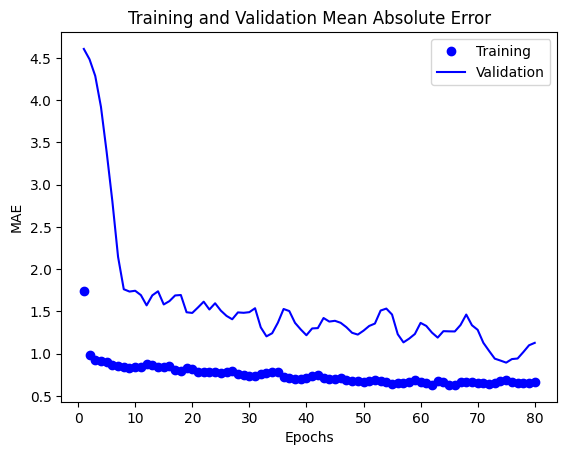

CPU times: user 2d 16min 2s, sys: 9min 41s, total: 2d 25min 44s
Wall time: 2h 25min 25s


In [53]:
%%time
# run k-fold cross validation
# timer
t = Timer()

# training and validation mean absolute error results
train_mae = []
val_mae = []

print(f'k-fold cross validation with {num_splits} splits for {epochs} epochs')
kf = KFold(n_splits=num_splits, shuffle=True, random_state=1202)
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f'  processing fold {i}')

    # split the data
    print('    splitting data')
    t.start()
    X_train_kf, X_val_kf, y_train_kf, y_val_kf = X_train[train_index], X_train[val_index], y_train[train_index], y_train[val_index]
    t.stop()

    # build the datasets
    print('    creating training dataset')
    t.start()
    train_ds = create_dataset(X_train_kf, y_train_kf, batch_size=batch_size, sort=True)
    t.stop()
    print('    creating validation dataset')
    t.start()
    val_ds = create_dataset(X_val_kf, y_val_kf, batch_size=batch_size, sort=True)
    t.stop()

    # fit the model and return mae
    print('    fitting model')
    t.start()
    t_mae, v_mae = run_model(augur_model(), train_ds, val_ds, epochs=epochs, start_epoch=1, oneshot=False, verbose=False)
    t.stop()

    # add returned mae values to the arrays
    train_mae.append(t_mae)
    val_mae.append(v_mae)

# calculate the average
average_train_mae = [ np.mean([ x[i] for x in train_mae ]) for i in range(epochs) ]
average_val_mae = [ np.mean([ x[i] for x in val_mae ]) for i in range(epochs) ]

# plot
plot_loss(average_train_mae, average_val_mae, start_epoch=1)

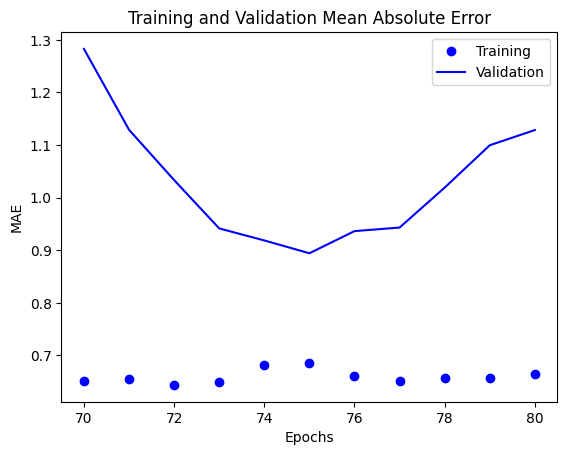

In [55]:
plot_loss(average_train_mae, average_val_mae, start_epoch=70)

In [56]:
# train final model

# model file name
model_name = 'model_augur_opt2.keras'

# timer
t = Timer()

# training and validation mean absolute error results
train_mae = []
val_mae = []

# number of epochs to train for
epochs = 75

print(f'training final model {model_name} for {epochs} epochs')

print('  creating training dataset')
t.start()
train_ds = create_dataset(X_train, y_train, batch_size=batch_size, sort=True)
t.stop()

print('  building model')
model = augur_model()

print('  training model')
t.start()
run_model(model, train_ds, None, epochs=epochs, start_epoch=1, oneshot=False, verbose=False)
t.stop()

print('  evaluating model')
mae = model.evaluate(test_ds)
print(f'  mean absolute evaluation error is {mae}')

print('  saving model')
model.save(model_name)

training final model model_augur_opt2.keras for 75 epochs
  creating training dataset
    elapsed time: 0.0622 seconds
  building model
  training model
    elapsed time: 1930.9827 seconds
  evaluating model
26/26 [==============================] - 1s 57ms/step - loss: 1.4040 - mean_absolute_error: 1.0068
  mean absolute evaluation error is [1.403968334197998, 1.0067604780197144]
  saving model


### Augur Model v6

In [ ]:
num_splits = 5
epochs = 75

k-fold cross validation with 5 splits for 75 epochs
  processing fold 0
    splitting data
    elapsed time: 0.0001 seconds
    creating training dataset
    elapsed time: 0.0453 seconds
    creating validation dataset
    elapsed time: 0.0153 seconds
    fitting model
    elapsed time: 1632.4966 seconds
  processing fold 1
    splitting data
    elapsed time: 0.0001 seconds
    creating training dataset
    elapsed time: 0.0463 seconds
    creating validation dataset
    elapsed time: 0.0179 seconds
    fitting model
    elapsed time: 1636.0385 seconds
  processing fold 2
    splitting data
    elapsed time: 0.0001 seconds
    creating training dataset
    elapsed time: 0.0455 seconds
    creating validation dataset
    elapsed time: 0.0159 seconds
    fitting model
    elapsed time: 1635.2652 seconds
  processing fold 3
    splitting data
    elapsed time: 0.0001 seconds
    creating training dataset
    elapsed time: 0.0453 seconds
    creating validation dataset
    elapsed time: 0

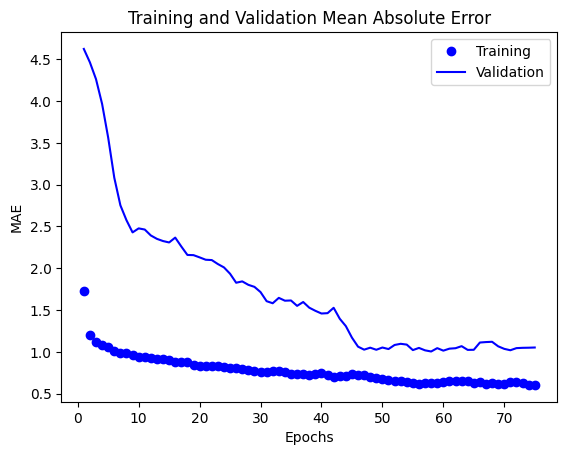

CPU times: user 1d 21h 13min 12s, sys: 9min 7s, total: 1d 21h 22min 20s
Wall time: 2h 16min 18s


In [61]:
%%time
# run k-fold cross validation
# timer
t = Timer()

# training and validation mean absolute error results
train_mae = []
val_mae = []

print(f'k-fold cross validation with {num_splits} splits for {epochs} epochs')
kf = KFold(n_splits=num_splits, shuffle=True, random_state=1202)
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f'  processing fold {i}')

    # split the data
    print('    splitting data')
    t.start()
    X_train_kf, X_val_kf, y_train_kf, y_val_kf = X_train[train_index], X_train[val_index], y_train[train_index], y_train[val_index]
    t.stop()

    # build the datasets
    print('    creating training dataset')
    t.start()
    train_ds = create_dataset(X_train_kf, y_train_kf, batch_size=batch_size, sort=True)
    t.stop()
    print('    creating validation dataset')
    t.start()
    val_ds = create_dataset(X_val_kf, y_val_kf, batch_size=batch_size, sort=True)
    t.stop()

    # fit the model and return mae
    print('    fitting model')
    t.start()
    t_mae, v_mae = run_model(augur_model_v6(), train_ds, val_ds, epochs=epochs, start_epoch=1, oneshot=False, verbose=False)
    t.stop()

    # add returned mae values to the arrays
    train_mae.append(t_mae)
    val_mae.append(v_mae)

# calculate the average
average_train_mae = [ np.mean([ x[i] for x in train_mae ]) for i in range(epochs) ]
average_val_mae = [ np.mean([ x[i] for x in val_mae ]) for i in range(epochs) ]

# plot
plot_loss(average_train_mae, average_val_mae, start_epoch=1)

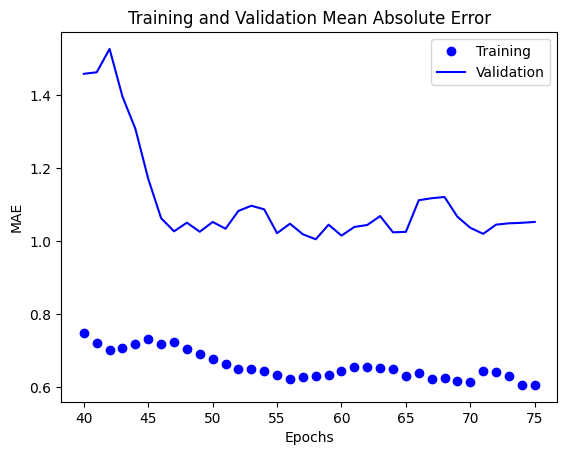

In [62]:
plot_loss(average_train_mae, average_val_mae, start_epoch=40)

In [65]:
# train final model

# model file name
model_name = 'model_augur_v6_opt2.keras'

# timer
t = Timer()

# training and validation mean absolute error results
train_mae = []
val_mae = []

# number of epochs to train for
epochs = 50

print(f'training final model {model_name} for {epochs} epochs')

print('  creating training dataset')
t.start()
train_ds = create_dataset(X_train, y_train, batch_size=batch_size, sort=True)
t.stop()

print('  building model')
model = augur_model_v6()

print('  training model')
t.start()
run_model(model, train_ds, None, epochs=epochs, start_epoch=1, oneshot=False, verbose=False)
t.stop()

print('  evaluating model')
mae = model.evaluate(test_ds)
print(f'  mean absolute evaluation error is {mae}')

print('  saving model')
model.save(model_name)

training final model model_augur_v6_opt2.keras for 50 epochs
  creating training dataset
    elapsed time: 0.0598 seconds
  building model
  training model
    elapsed time: 1287.5495 seconds
  evaluating model
26/26 [==============================] - 1s 57ms/step - loss: 1.5409 - mean_absolute_error: 1.0606
  mean absolute evaluation error is [1.5409473180770874, 1.0606001615524292]
  saving model


### Augur Model v7

In [78]:
num_splits = 5
epochs = 75

k-fold cross validation with 5 splits for 75 epochs
  processing fold 0
    splitting data
    elapsed time: 0.0001 seconds
    creating training dataset
    elapsed time: 0.0493 seconds
    creating validation dataset
    elapsed time: 0.0149 seconds
    fitting model
    elapsed time: 1001.8811 seconds
  processing fold 1
    splitting data
    elapsed time: 0.0001 seconds
    creating training dataset
    elapsed time: 0.0509 seconds
    creating validation dataset
    elapsed time: 0.0162 seconds
    fitting model
    elapsed time: 1004.5021 seconds
  processing fold 2
    splitting data
    elapsed time: 0.0001 seconds
    creating training dataset
    elapsed time: 0.0503 seconds
    creating validation dataset
    elapsed time: 0.0185 seconds
    fitting model
    elapsed time: 1003.4967 seconds
  processing fold 3
    splitting data
    elapsed time: 0.0002 seconds
    creating training dataset
    elapsed time: 0.0480 seconds
    creating validation dataset
    elapsed time: 0

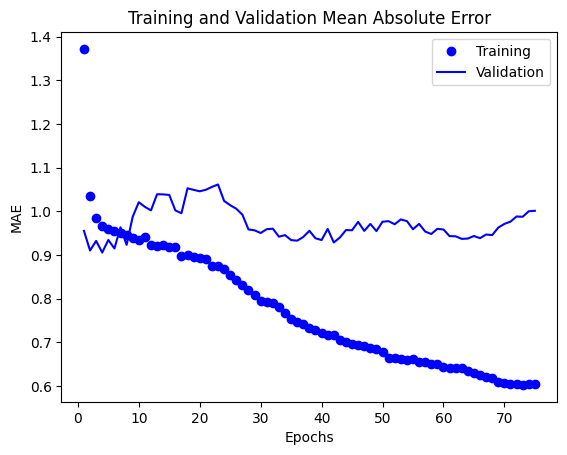

CPU times: user 1d 2h 24min 4s, sys: 7min 52s, total: 1d 2h 31min 57s
Wall time: 1h 23min 40s


In [79]:
%%time
# run k-fold cross validation
# timer
t = Timer()

# training and validation mean absolute error results
train_mae = []
val_mae = []

print(f'k-fold cross validation with {num_splits} splits for {epochs} epochs')
kf = KFold(n_splits=num_splits, shuffle=True, random_state=1202)
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f'  processing fold {i}')

    # split the data
    print('    splitting data')
    t.start()
    X_train_kf, X_val_kf, y_train_kf, y_val_kf = X_train[train_index], X_train[val_index], y_train[train_index], y_train[val_index]
    t.stop()

    # build the datasets
    print('    creating training dataset')
    t.start()
    train_ds = create_dataset(X_train_kf, y_train_kf, batch_size=batch_size, sort=True)
    t.stop()
    print('    creating validation dataset')
    t.start()
    val_ds = create_dataset(X_val_kf, y_val_kf, batch_size=batch_size, sort=True)
    t.stop()

    # fit the model and return mae
    print('    fitting model')
    t.start()
    t_mae, v_mae = run_model(augur_model_v7(), train_ds, val_ds, epochs=epochs, start_epoch=1, oneshot=False, verbose=False)
    t.stop()

    # add returned mae values to the arrays
    train_mae.append(t_mae)
    val_mae.append(v_mae)

# calculate the average
average_train_mae = [ np.mean([ x[i] for x in train_mae ]) for i in range(epochs) ]
average_val_mae = [ np.mean([ x[i] for x in val_mae ]) for i in range(epochs) ]

# plot
plot_loss(average_train_mae, average_val_mae, start_epoch=1)

In [80]:
v7_train_mae = average_train_mae
v7_val_mae = average_val_mae

In [ ]:
plot_loss(average_train_mae, average_val_mae, start_epoch=30)

In [ ]:
# train final model

# model file name
model_name = 'model_augur_v7_opt2.keras'

# timer
t = Timer()

# training and validation mean absolute error results
train_mae = []
val_mae = []

# number of epochs to train for
epochs = 40

print(f'training final model {model_name} for {epochs} epochs')

print('  creating training dataset')
t.start()
train_ds = create_dataset(X_train, y_train, batch_size=batch_size, sort=True)
t.stop()

print('  building model')
model = augur_model_v7()

print('  training model')
t.start()
run_model(model, train_ds, None, epochs=epochs, start_epoch=1, oneshot=False, verbose=False)
t.stop()

print('  evaluating model')
mae = model.evaluate(test_ds)
print(f'  mean absolute evaluation error is {mae}')

print('  saving model')
model.save(model_name)

### Augur Model v8

In [81]:
num_splits = 5
epochs = 75

k-fold cross validation with 5 splits for 75 epochs
  processing fold 0
    splitting data
    elapsed time: 0.0001 seconds
    creating training dataset
    elapsed time: 0.0554 seconds
    creating validation dataset
    elapsed time: 0.0212 seconds
    fitting model
    elapsed time: 6098.0373 seconds
  processing fold 1
    splitting data
    elapsed time: 0.0002 seconds
    creating training dataset
    elapsed time: 0.0478 seconds
    creating validation dataset
    elapsed time: 0.0191 seconds
    fitting model
    elapsed time: 6113.4180 seconds
  processing fold 2
    splitting data
    elapsed time: 0.0001 seconds
    creating training dataset
    elapsed time: 0.0479 seconds
    creating validation dataset
    elapsed time: 0.0190 seconds
    fitting model
    elapsed time: 6111.3706 seconds
  processing fold 3
    splitting data
    elapsed time: 0.0002 seconds
    creating training dataset
    elapsed time: 0.0477 seconds
    creating validation dataset
    elapsed time: 0

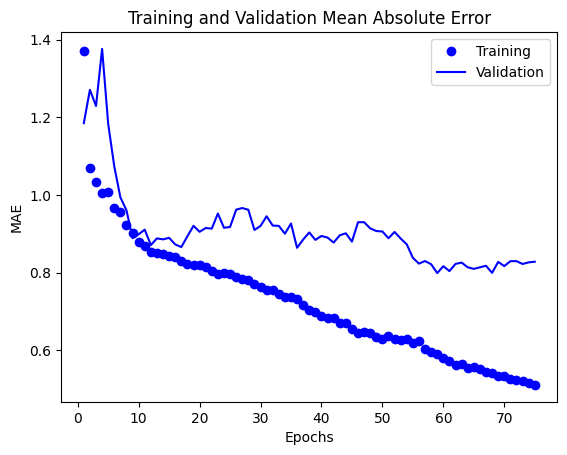

CPU times: user 6d 16h 59min 56s, sys: 43min 5s, total: 6d 17h 43min 2s
Wall time: 8h 29min 9s


In [82]:
%%time
# run k-fold cross validation
# timer
t = Timer()

# training and validation mean absolute error results
train_mae = []
val_mae = []

print(f'k-fold cross validation with {num_splits} splits for {epochs} epochs')
kf = KFold(n_splits=num_splits, shuffle=True, random_state=1202)
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f'  processing fold {i}')

    # split the data
    print('    splitting data')
    t.start()
    X_train_kf, X_val_kf, y_train_kf, y_val_kf = X_train[train_index], X_train[val_index], y_train[train_index], y_train[val_index]
    t.stop()

    # build the datasets
    print('    creating training dataset')
    t.start()
    train_ds = create_dataset(X_train_kf, y_train_kf, batch_size=batch_size, sort=True)
    t.stop()
    print('    creating validation dataset')
    t.start()
    val_ds = create_dataset(X_val_kf, y_val_kf, batch_size=batch_size, sort=True)
    t.stop()

    # fit the model and return mae
    print('    fitting model')
    t.start()
    t_mae, v_mae = run_model(augur_model_v8(), train_ds, val_ds, epochs=epochs, start_epoch=1, oneshot=False, verbose=False)
    t.stop()

    # add returned mae values to the arrays
    train_mae.append(t_mae)
    val_mae.append(v_mae)

# calculate the average
average_train_mae = [ np.mean([ x[i] for x in train_mae ]) for i in range(epochs) ]
average_val_mae = [ np.mean([ x[i] for x in val_mae ]) for i in range(epochs) ]

# plot
plot_loss(average_train_mae, average_val_mae, start_epoch=1)

In [83]:
v8_train_mae = average_train_mae
v8_val_mae = average_val_mae

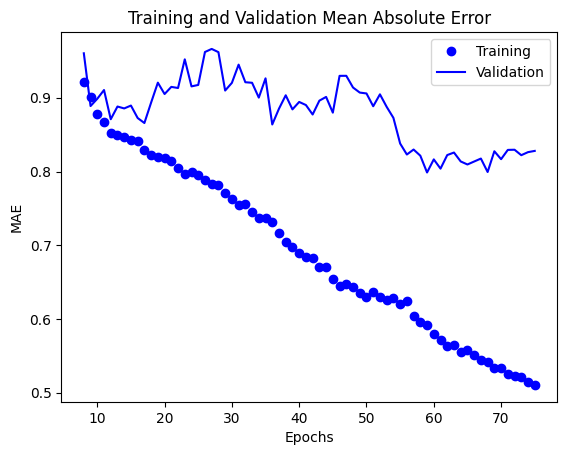

In [84]:
plot_loss(average_train_mae, average_val_mae, start_epoch=8)

In [89]:
# train final model

# model file name
model_name = 'model_augur_v8_opt2.keras'

# timer
t = Timer()

# training and validation mean absolute error results
train_mae = []
val_mae = []

# number of epochs to train for
epochs = 60

print(f'training final model {model_name} for {epochs} epochs')

print('  creating training dataset')
t.start()
train_ds = create_dataset(X_train, y_train, batch_size=batch_size, sort=True)
t.stop()

print('  building model')
model = augur_model_v8()

print('  training model')
t.start()
run_model(model, train_ds, None, epochs=epochs, start_epoch=1, oneshot=False, verbose=False)
t.stop()

print('  evaluating model')
mae = model.evaluate(test_ds)
print(f'  mean absolute evaluation error is {mae}')

print('  saving model')
model.save(model_name)

training final model model_augur_v8_opt2.keras for 60 epochs
  creating training dataset
    elapsed time: 0.0584 seconds
  building model
  training model
    elapsed time: 5664.2213 seconds
  evaluating model
26/26 [==============================] - 7s 276ms/step - loss: 0.9784 - mean_absolute_error: 0.8025
  mean absolute evaluation error is [0.9783755540847778, 0.8025185465812683]
  saving model


### Augur Model v9

In [90]:
num_splits = 5
epochs = 75

k-fold cross validation with 5 splits for 75 epochs
  processing fold 0
    splitting data
    elapsed time: 0.0001 seconds
    creating training dataset
    elapsed time: 0.0485 seconds
    creating validation dataset
    elapsed time: 0.0189 seconds
    fitting model
    elapsed time: 7324.2434 seconds
  processing fold 1
    splitting data
    elapsed time: 0.0001 seconds
    creating training dataset
    elapsed time: 0.0475 seconds
    creating validation dataset
    elapsed time: 0.0187 seconds
    fitting model
    elapsed time: 7332.2216 seconds
  processing fold 2
    splitting data
    elapsed time: 0.0001 seconds
    creating training dataset
    elapsed time: 0.0460 seconds
    creating validation dataset
    elapsed time: 0.0179 seconds
    fitting model
    elapsed time: 7330.5162 seconds
  processing fold 3
    splitting data
    elapsed time: 0.0001 seconds
    creating training dataset
    elapsed time: 0.0459 seconds
    creating validation dataset
    elapsed time: 0

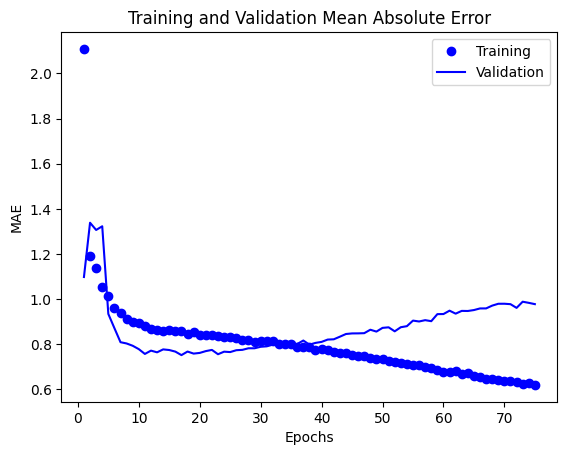

CPU times: user 8d 33min 44s, sys: 1h 46min 20s, total: 8d 2h 20min 4s
Wall time: 10h 11min 5s


In [91]:
%%time
# run k-fold cross validation
# timer
t = Timer()

# training and validation mean absolute error results
train_mae = []
val_mae = []

print(f'k-fold cross validation with {num_splits} splits for {epochs} epochs')
kf = KFold(n_splits=num_splits, shuffle=True, random_state=1202)
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f'  processing fold {i}')

    # split the data
    print('    splitting data')
    t.start()
    X_train_kf, X_val_kf, y_train_kf, y_val_kf = X_train[train_index], X_train[val_index], y_train[train_index], y_train[val_index]
    t.stop()

    # build the datasets
    print('    creating training dataset')
    t.start()
    train_ds = create_dataset(X_train_kf, y_train_kf, batch_size=batch_size, sort=True)
    t.stop()
    print('    creating validation dataset')
    t.start()
    val_ds = create_dataset(X_val_kf, y_val_kf, batch_size=batch_size, sort=True)
    t.stop()

    # fit the model and return mae
    print('    fitting model')
    t.start()
    t_mae, v_mae = run_model(augur_model_v9(), train_ds, val_ds, epochs=epochs, start_epoch=1, oneshot=False, verbose=False)
    t.stop()

    # add returned mae values to the arrays
    train_mae.append(t_mae)
    val_mae.append(v_mae)

# calculate the average
average_train_mae = [ np.mean([ x[i] for x in train_mae ]) for i in range(epochs) ]
average_val_mae = [ np.mean([ x[i] for x in val_mae ]) for i in range(epochs) ]

# plot
plot_loss(average_train_mae, average_val_mae, start_epoch=1)

In [93]:
v9_train_mae = average_train_mae
v9_val_mae = average_val_mae

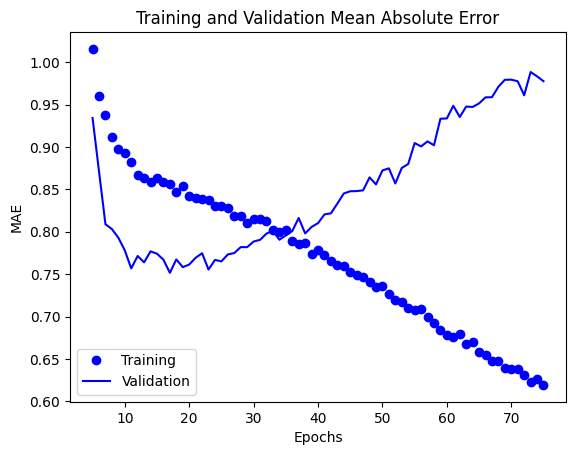

In [95]:
plot_loss(average_train_mae, average_val_mae, start_epoch=5)

In [ ]:
# train final model

# model file name
model_name = 'model_augur_v9_opt2.keras'

# timer
t = Timer()

# training and validation mean absolute error results
train_mae = []
val_mae = []

# number of epochs to train for
epochs = 20

print(f'training final model {model_name} for {epochs} epochs')

print('  creating training dataset')
t.start()
train_ds = create_dataset(X_train, y_train, batch_size=batch_size, sort=True)
t.stop()

print('  building model')
model = augur_model_v9()

print('  training model')
t.start()
run_model(model, train_ds, None, epochs=epochs, start_epoch=1, oneshot=False, verbose=False)
t.stop()

print('  evaluating model')
mae = model.evaluate(test_ds)
print(f'  mean absolute evaluation error is {mae}')

print('  saving model')
model.save(model_name)

training final model model_augur_v9_opt2.keras for 20 epochs
  creating training dataset
    elapsed time: 0.0713 seconds
  building model
  training model


### DZ Model

In [ ]:
num_splits = 5
epochs = 40

In [ ]:
%%time
# run k-fold cross validation
# timer
t = Timer()

# training and validation mean absolute error results
train_mae = []
val_mae = []

print(f'k-fold cross validation with {num_splits} splits for {epochs} epochs')
kf = KFold(n_splits=num_splits, shuffle=True, random_state=1202)
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f'  processing fold {i}')

    # split the data
    print('    splitting data')
    t.start()
    X_train_kf, X_val_kf, y_train_kf, y_val_kf = X_train[train_index], X_train[val_index], y_train[train_index], y_train[val_index]
    t.stop()

    # build the datasets
    print('    creating training dataset')
    t.start()
    train_ds = create_dataset(X_train_kf, y_train_kf, batch_size=batch_size, sort=True)
    t.stop()
    print('    creating validation dataset')
    t.start()
    val_ds = create_dataset(X_val_kf, y_val_kf, batch_size=batch_size, sort=False)
    t.stop()

    # fit the model and return mae
    print('    fitting model')
    t.start()
    t_mae, v_mae = run_model(dan_zrimec_model(), train_ds, val_ds, epochs=epochs, start_epoch=1, oneshot=False, verbose=False)
    t.stop()

    # add returned mae values to the arrays
    train_mae.append(t_mae)
    val_mae.append(v_mae)

# calculate the average
average_train_mae = [ np.mean([ x[i] for x in train_mae ]) for i in range(epochs) ]
average_val_mae = [ np.mean([ x[i] for x in val_mae ]) for i in range(epochs) ]

# plot
plot_loss(average_train_mae, average_val_mae, start_epoch=1)

# what are the steps?

- create ragged tensor from X_test
- create dataset from X_test and y_test

k-fold cross validation for the baseline neural network
- input is X_train, y_train
- using KFold this will be split in k folds
  - sort the trainin part
  - convert X to ragged tensor
  - create dataset
  - train
  - evaluate
- evaluate the cross fold performance
- rerun model with the whole dataset (test+val)
- save the model
```
kf = KFold(n_splits=num_splits, shuffle=True, random_state=1202)
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f"Fold {i}:")
    X_train_kf, X_test_kf, y_train_kf, y_test_kf = X_train[train_index], X_train[test_index], y_train[train_index], y_train[test_index]
    # sort X_train_kf and y_train_kf
    # convert X_train_kf to ragged tensor
    # create dataset from X_train_kf and y_train_kf
    # do the training and evaluation
# evaluate the cross fold performance
```

train/val split for the full neural network -> separate jupyter notebook
- input X_train, y_train
- split the training test set again in train and val
- create ragged tensor from training X
- create dataset from training X and y
- train
- evaluate
- rerun the model with the whole dataset (test+val)
- save the model


what have both in common?
- data load and initial prep (up to the first split)
- model setup
- training setup
- visualisation
- evaluation -> this is just one command

helpful methods
- create_dataset(X, y, sort=False)
  input X and y, specify if the dataset should be sorted
  returns a TF dataset
- run_model(model, epochs, plot=True, plot_epoch_start=0)
- plot_loss()

- callbacks
    - earlystopping -> to limit training that doesn't progress, only for the tuner
    - backupandrestore -> for the full training as fault tolerance setup
    - modelcheckpoint -> to save the best model on the final train

In [ ]:
# split the train set again in train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1202)

In [ ]:
# find the first unique PTR value that is also in y_train
train_idx = 0
for i in range(len(y)):
    count = 0
    for l in range(len(y)):
        if i != l and y[i] == y[l]:
            count += 1
            continue
    if count == 0:
        for m in range(len(y_train)):
            if y[i] == y_train[m]:
                train_idx = m
                break
train_idx

In [ ]:
# get a sample
X_train[train_idx]

In [ ]:
# get the matching target
search_y = y_train[train_idx]
search_y

In [ ]:
# find the target value in the raw dataset
full_idx = 0
for i in range(len(y)):
    if y[i] == search_y:
        print(i)
        full_idx = i

In [ ]:
# compare if the raw dataset entry matches the subset entry
if X[full_idx].all() == X_train[train_idx].all():
    print('OK')

### Sort Training Data

In [ ]:
# build an inhomogenous numpy array from the training set
X_train = np.array(X_train, dtype=object)

In [ ]:
# build an array containing the sequence lengths
sequence_lengths = list(map(lambda x: len(x), X_train))

In [ ]:
# sort the array but only get the indices
sorted_indices = np.argsort(sequence_lengths)

In [ ]:
sorted_indices

In [ ]:
# now sort the X and y train arrays according to the sorted indicds
X_train = X_train[sorted_indices]
y_train = y_train[sorted_indices]

In [ ]:
# check if the previously found values still correlate
for i in range(len(y_train)):
    if y_train[i] == search_y:
        print(X_train[i])

### Ragged Tensor Tests

In [ ]:
# this does not work since the sequences are of different length
# X_test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
%%time
X_train_tensor = tf.ragged.constant(X_train, dtype=tf.int8, ragged_rank=1, row_splits_dtype=tf.int32)
X_val_tensor = tf.ragged.constant(X_val, dtype=tf.int8, ragged_rank=1, row_splits_dtype=tf.int32)

In [ ]:
X_train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tensor, y_train))
X_val_dataset = tf.data.Dataset.from_tensor_slices((X_val_tensor, y_val))

In [ ]:
X_train_dataset.element_spec

In [ ]:
X_val_dataset.element_spec

In [ ]:
# padded batches from ragged tensors are not supported (yet)
# it needs a work around creating a uniform tensor
# idea from : https://github.com/tensorflow/tensorflow/issues/39163
def reformat(data, label):
    return data, label

In [ ]:
X_train_dataset = X_train_dataset.map(reformat)
X_val_dataset = X_val_dataset.map(reformat)

In [ ]:
# shuffle the dataset (again) and create padded batches
batch_size = 64
X_train_dataset = X_train_dataset.padded_batch(batch_size)
X_val_dataset = X_val_dataset.shuffle(buffer_size=len(X_val), seed=1202).padded_batch(batch_size)

In [ ]:
# optinally repeat the dataset multiple times -> WHY?
# rep = 3
# X_train_dataset = X_train_dataset.repeat(rep)
# X_val_dataset = X_val_dataset.repeat(rep)

In [ ]:
datalen = []
ds_iterator = iter(X_train_dataset)
for data, label in ds_iterator:
    datalen.append(len(data[1]))

In [ ]:
datalen[:5]

In [ ]:
# testing if keras can use the dataset
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(None,4)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(X_train_dataset, epochs=1)